In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/leukemia cancer classification

# General

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from imblearn.metrics import sensitivity_specificity_support
import seaborn as sn
import pandas as pd
from sklearn import metrics

In [ ]:
path, dirs, files = next(os.walk("Dataset/train/all"))
file_count = len(files)
print("Apnormal : ",file_count)
path, dirs, files = next(os.walk("Dataset/train/hem"))
file_count = len(files)
print("Normal : ",file_count)

In [ ]:
def Read_Dataset(image_size, batch_size):

  train_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/train",
      image_size = image_size,
      batch_size = batch_size,
  )

  val_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/val",
      image_size = image_size,
      batch_size = batch_size,
  )

  test_df = tf.keras.preprocessing.image_dataset_from_directory(
      "Dataset/test",
      image_size = image_size,
      batch_size = batch_size,
      shuffle = False,
  )

  train_df = train_df.prefetch(buffer_size = 32)

  val_df = val_df.prefetch(buffer_size = 32)

  y_test = np.concatenate([y for x, y in test_df], axis = 0)

  return train_df, val_df, test_df, y_test

In [ ]:
def get_callbacks(model_name):
  callbacks = []

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f'model.{model_name}.h5', verbos = 1, monitor = 'val_loss', mode = "min", save_best_only = True, save_freq = "epoch")
  callbacks.append(checkpoint)
  anne = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = 2, min_lr = 0.0000001, min_delta = 0.00001, mode = "auto")
  callbacks.append(anne)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  callbacks.append(earlystop)

  return callbacks

In [ ]:
def Create_Model(model_name, IMG_SHAPE):
  OPTIMIZER = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

  if model_name == "MobileNet":
    base_model = tf.keras.applications.MobileNet(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "ResNet50":
    base_model = tf.keras.applications.ResNet50(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "InceptionResNetV2":
     base_model = tf.keras.applications.InceptionResNetV2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB2":
    base_model = tf.keras.applications.EfficientNetB2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "NASNetMobile":
    base_model = tf.keras.applications.NASNetMobile(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")
  elif model_name == "EfficientNetB4":
    base_model = tf.keras.applications.EfficientNetB4(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")

  elif model_name == "ResNet152V2":
    base_model = tf.keras.applications.ResNet152V2(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet")

  base_model.trainable = True
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  predictions = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Final')(x)
  model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

  model.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(.5)])

  return model

In [ ]:
def Train_Validation(epoches, acc, val_acc, loss, val_loss):
  plt.plot(epoches, acc, label = 'Training accuarcy')
  plt.plot(epoches, val_acc, label = 'Validation accuarcy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epoches, loss, label = 'Training loss')
  plt.plot(epoches, val_loss, label = 'Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [ ]:
def predict(test_df, y_test):
  y_pred = model.predict(test_df, verbose = 1).round()
  y_pred = y_pred.flatten()
  
  target_names = ['Class Normal', 'Class ApNormal']
  return classification_report(y_test, y_pred, target_names = target_names, digits = 4), y_pred

In [ ]:
def Confusion(y_test, y_pred, model_name):
  disp = metrics.confusion_matrix(y_test, y_pred)
  disp.astype('int')
  pd.options.display.float_format = '{:.5f}'.format
  target_names = ['Normal', 'ApNormal']
  df_cm = pd.DataFrame(disp, target_names, target_names)
  fig, ax = plt.subplots(figsize = (4,4))
  sn.set(font_scale = 1.5)
  sn.heatmap(df_cm, annot = True, annot_kws = {"size": 15}, ax = ax, cmap = "YlOrBr", fmt = 'g', cbar = False)
  plt.ylabel('Actual', fontsize = 20)
  plt.ylabel('Predicted', fontsize = 20)
  plt.ioff()
  plt.savefig(f"confusion_mat_{model_name}", bbox_inches = 'tight')
  plt.show()

# MobileNet

In [ ]:
train_df, val_df, test_df, y_test = Read_Dataset((224,224),32)

In [ ]:
model = Create_Model("MobileNet",(224,224,3))
print(model.summary())

In [ ]:
callbacks = get_callbacks("MobileNet")
history = model.fit(train_df, epochs = 50, validation_data = val_df, callbacks = [callbacks])

Epoch 1/50
348/348 [==============================] - 93s 262ms/step - loss: 0.0062 - accuracy: 0.9978 - precision: 0.9975 - recall: 0.9979 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.1939 - val_accuracy: 0.9550 - val_precision: 0.9606 - val_recall: 0.9418 - val_specificity_at_sensitivity: 0.9959 - val_sensitivity_at_specificity: 0.9797 - lr: 2.5000e-04
Epoch 2/50
348/348 [==============================] - 91s 258ms/step - loss: 0.0024 - accuracy: 0.9992 - precision: 0.9994 - recall: 0.9988 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000 - val_loss: 0.1866 - val_accuracy: 0.9569 - val_precision: 0.9589 - val_recall: 0.9479 - val_specificity_at_sensitivity: 0.9935 - val_sensitivity_at_specificity: 0.9817 - lr: 2.5000e-04
Epoch 3/50
348/348 [==============================] - 92s 262ms/step - loss: 0.0028 - accuracy: 0.9993 - precision: 0.9994 - recall: 0.9990 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specif

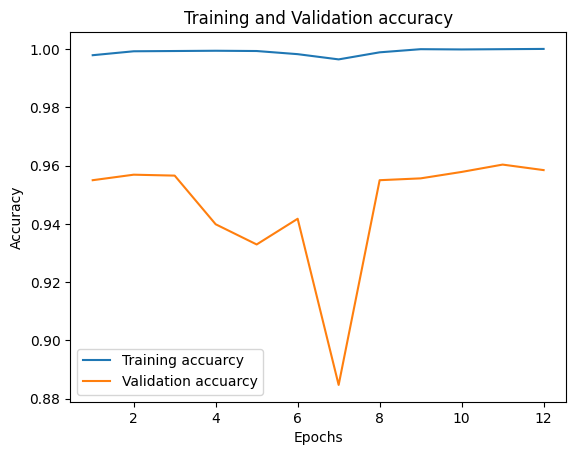

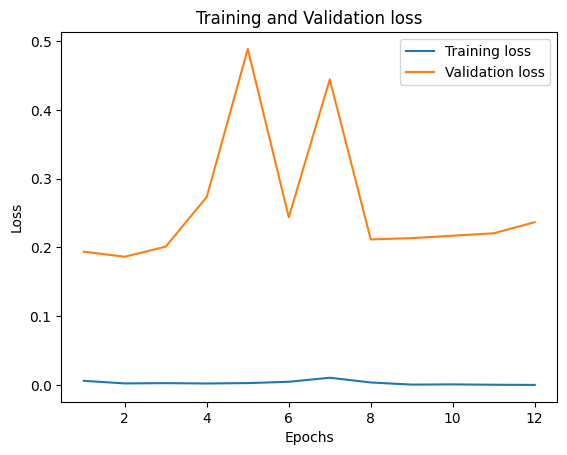

In [ ]:
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epoches = range(1, len(acc) + 1)

Train_Validation(epoches, acc, val_acc, loss, val_loss)

In [ ]:
results = model.evaluate(test_df, verbose = 1)

50/50 [==============================] - 9s 186ms/step - loss: 0.2563 - accuracy: 0.9591 - precision: 0.9734 - recall: 0.9378 - specificity_at_sensitivity: 0.9953 - sensitivity_at_specificity: 0.9622


In [ ]:
report, y_pred = predict(test_df, y_test)
print(report)

50/50 [==============================] - 5s 99ms/step
                precision    recall  f1-score   support

  Class Normal     0.9475    0.9776    0.9624       850
Class ApNormal     0.9734    0.9378    0.9553       740

      accuracy                         0.9591      1590
     macro avg     0.9605    0.9577    0.9588      1590
  weighted avg     0.9596    0.9591    0.9591      1590



              precision    recall  f1-score   support

      Normal     0.9475    0.9776    0.9624       850
    ApNormal     0.9734    0.9378    0.9553       740

    accuracy                         0.9591      1590
   macro avg     0.9605    0.9577    0.9588      1590
weighted avg     0.9596    0.9591    0.9591      1590



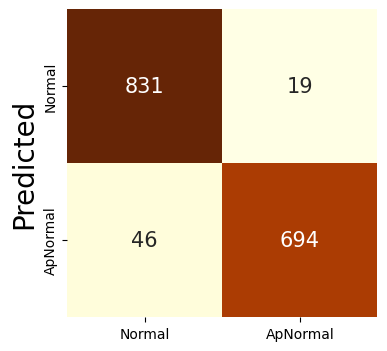

In [ ]:
report = classification_report(y_test, y_pred, target_names = ['Normal', 'ApNormal'], digits = 4)
print(report)

Confusion(y_test, y_pred, "MobileNet")

# ResNet50

In [ ]:
model = Create_Model("ResNet50",(224,224,3))
print(model.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
callbacks = get_callbacks("ResNet50")
history = model.fit(train_df, epochs = 50, validation_data = val_df, callbacks = [callbacks])

Epoch 1/50
348/348 [==============================] - 202s 424ms/step - loss: 0.3598 - accuracy: 0.8458 - precision_1: 0.8792 - recall_1: 0.7743 - specificity_at_sensitivity_1: 0.9963 - sensitivity_at_specificity_1: 0.9449 - val_loss: 0.8584 - val_accuracy: 0.5285 - val_precision_1: 0.4966 - val_recall_1: 0.9953 - val_specificity_at_sensitivity_1: 0.9882 - val_sensitivity_at_specificity_1: 0.9242 - lr: 0.0010
Epoch 2/50
348/348 [==============================] - 135s 382ms/step - loss: 0.2872 - accuracy: 0.8817 - precision_1: 0.9139 - recall_1: 0.8229 - specificity_at_sensitivity_1: 0.9997 - sensitivity_at_specificity_1: 0.9685 - val_loss: 4.1154 - val_accuracy: 0.4652 - val_precision_1: 0.4652 - val_recall_1: 1.0000 - val_specificity_at_sensitivity_1: 0.1166 - val_sensitivity_at_specificity_1: 0.0000e+00 - lr: 0.0010
Epoch 3/50
348/348 [==============================] - 133s 379ms/step - loss: 0.2597 - accuracy: 0.8909 - precision_1: 0.9214 - recall_1: 0.8364 - specificity_at_sensitiv

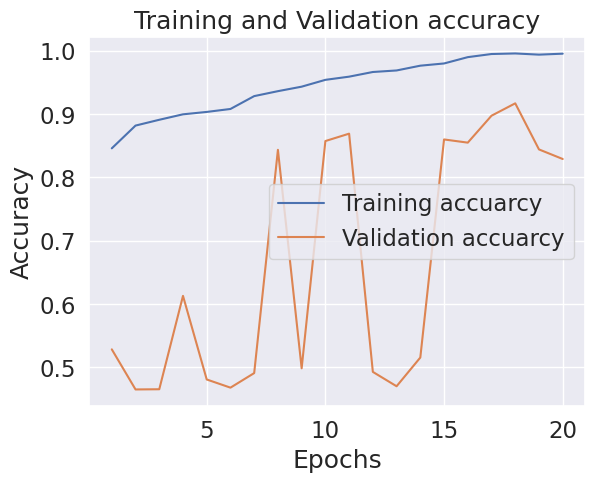

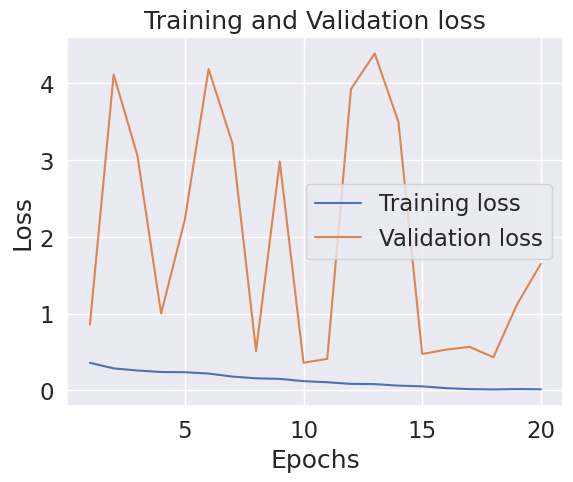

In [ ]:
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epoches = range(1, len(acc) + 1)

Train_Validation(epoches, acc, val_acc, loss, val_loss)

In [ ]:
results = model.evaluate(test_df, verbose = 1)

50/50 [==============================] - 11s 205ms/step - loss: 1.9449 - accuracy: 0.8107 - precision_1: 0.9933 - recall_1: 0.5973 - specificity_at_sensitivity_1: 0.9988 - sensitivity_at_specificity_1: 0.7108


In [ ]:
report, y_pred = predict(test_df, y_test)
print(report)

50/50 [==============================] - 11s 199ms/step
                precision    recall  f1-score   support

  Class Normal     0.7397    0.9965    0.8491       850
Class ApNormal     0.9933    0.5973    0.7460       740

      accuracy                         0.8107      1590
     macro avg     0.8665    0.7969    0.7976      1590
  weighted avg     0.8577    0.8107    0.8011      1590



              precision    recall  f1-score   support

      Normal     0.7397    0.9965    0.8491       850
    ApNormal     0.9933    0.5973    0.7460       740

    accuracy                         0.8107      1590
   macro avg     0.8665    0.7969    0.7976      1590
weighted avg     0.8577    0.8107    0.8011      1590



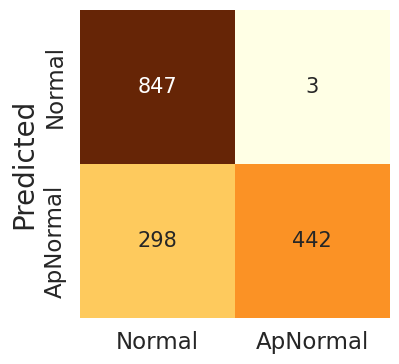

In [ ]:
report = classification_report(y_test, y_pred, target_names = ['Normal', 'ApNormal'], digits = 4)
print(report)

Confusion(y_test, y_pred, "ResNet50")